In [2]:
%load_ext tensorboard

In [27]:
import os
import numpy as np
import time
import tensorflow as tf
import datetime
import matplotlib.pyplot as plt
seed = 5691
np.random.seed(seed)
tf.random.set_seed(seed)
NUM_OF_CATEGORY = 10

In [28]:
mnist = tf.keras.datasets.fashion_mnist
# mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = np.reshape(x_train / 255.0, (int(tf.shape(x_train)[0]),-1)), np.reshape(x_test / 255.0, (int(tf.shape(x_test)[0]),-1))
one_hot_y = lambda t: [1 if i == t else 0 for i in range(NUM_OF_CATEGORY)]
y_train, y_test = np.array([one_hot_y(y) for y in y_train]), np.array([one_hot_y(y) for y in y_test])


In [29]:
class MLP(tf.keras.Model):
    def __init__(self, size_input, size_hidden, size_output, device=None):
        super(MLP, self).__init__()
        """
        size_input: int, size of input layer
        size_hidden: int, size of hidden layer
        size_output: int, size of output layer
        device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
        """
        self.size_input, self.size_hidden, self.size_output, self.device =\
        size_input, size_hidden, size_output, device

        # Initialize weights between input layer and hidden layer 1
        self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden], seed=seed))
        # Initialize biases for hidden layer 1
        self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden], seed=seed))
         # Initialize weights between hidden layer 1 and hidden layer 2
        self.W2 = tf.Variable(tf.random.normal([self.size_hidden, self.size_hidden], seed=seed))
        # Initialize biases for hidden layer 2
        self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden], seed=seed))
         # Initialize weights between hidden layer 2 and output layer
        self.W3 = tf.Variable(tf.random.normal([self.size_hidden, self.size_output], seed=seed))
        # Initialize biases for output layer
        self.b3 = tf.Variable(tf.random.normal([1, self.size_output], seed=seed))

        # Define variables to be updated during backpropagation
        self.MLP_variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
        # self.MLP_variables = [self.W1, self.W3, self.b1, self.b3]

    
    def forward(self, X, dropout_rate=0):
        """
        forward pass
        X: Tensor, inputs
        """
        if self.device is not None:
            with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
                self.y = self.compute_output(X, dropout_rate=dropout_rate)
        else:
            self.y = self.compute_output(X, dropout_rate=dropout_rate)

        return self.y
  
    def loss(self, y_pred, y_true, L1=0, L2=0):
        '''
        y_pred - Tensor of shape (batch_size, size_output)
        y_true - Tensor of shape (batch_size, size_output)
        '''
        y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
        y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
        l2_penlty = tf.nn.l2_loss(self.W1)*L2
        loss_with_l2 = l2_penlty+tf.losses.categorical_crossentropy(y_true_tf, y_pred_tf)
        return tf.losses.categorical_crossentropy(y_true_tf, y_pred_tf)
  
    def backward(self, X_train, y_train, dropout_rate, learning_rate, L1=0, L2=0):
        """
        backward pass
        """
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        with tf.GradientTape() as tape:
            predicted = self.forward(X_train,dropout_rate=dropout_rate)
            current_loss = self.loss(predicted, y_train)
        grads = tape.gradient(current_loss, self.MLP_variables)
        optimizer.apply_gradients(zip(grads, self.MLP_variables))
        return current_loss, predicted
        
        
    def compute_output(self, X, dropout_rate=0):
        """
        Custom method to obtain output tensor during forward pass
        """
        # Cast X to float32
        X_tf = tf.cast(X, dtype=tf.float32)
        #Remember to normalize your dataset before moving forward
        # Compute values in hidden layer 1
        what = tf.matmul(X_tf, self.W1) + self.b1
        hhat = tf.nn.relu(what)
        # Implement Dropout
        hhat = tf.nn.dropout(hhat, rate = dropout_rate, seed=seed)

        # Compute values in hidden layer 2
        what = tf.matmul(hhat, self.W2) + self.b2
        hhat = tf.nn.relu(what)
        # Implement Dropout
        hhat = tf.nn.dropout(hhat, rate = dropout_rate, seed=seed)

        # Compute output
        output = tf.matmul(hhat, self.W3) + self.b3
        #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
        #Second add tf.Softmax(output) and then return this variable
        return tf.nn.softmax(output)
#         return output


In [26]:
# Set hyper-parameters

DROPOUT_RATE = 0.4
BATCH_SIZE = 200
HIDDEN_SIZE = 256
NUM_EPOCHS = 150
LEARNING_RATE = 0.003
L2_PENLTY = 0

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
path = f"SEED_{seed}-LearnRate_{LEARNING_RATE}-L2_{L2_PENLTY}-DROPOUT_{DROPOUT_RATE}-BATCH_{BATCH_SIZE}-HIDDEN_{HIDDEN_SIZE}-TIME_{current_time}"

# Set log summary

train_log_dir = 'logs/mnist_fashion/' + path + '/train'
test_log_dir = 'logs/mnist_fashion/' + path + '/test'
# train_log_dir = 'logs/mnist/' + path + '/train'
# test_log_dir = 'logs/mnist/' + path + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)


size_input = int(tf.shape(x_train)[1])
size_hidden = HIDDEN_SIZE
size_output = int(tf.shape(y_train)[1])
number_of_train_examples = int(tf.shape(x_train)[0])
number_of_test_examples = int(tf.shape(x_test)[0])


# print("size_input",size_input)
# print("size_output",size_output)
# print("number_of_train_examples",number_of_train_examples)
# print("number_of_test_examples",number_of_test_examples)


mlp_on_gpu = MLP(size_input, size_hidden, size_output, device='cpu')
time_start = time.time()
epoch = 1
loss_diff,last_loss = 1,0

while epoch <= NUM_EPOCHS and abs(loss_diff) > 0.00001:
    loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
    train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(BATCH_SIZE+BATCH_SIZE//4, seed=epoch*(seed)).batch(BATCH_SIZE)
    for inputs, outputs in train_ds:
        cur_loss, preds = mlp_on_gpu.backward(inputs, outputs, dropout_rate=DROPOUT_RATE, learning_rate=LEARNING_RATE, L2=L2_PENLTY)
        loss_total_gpu += cur_loss
  # Calculate Accuracy
    train_accuracy, test_accuracy = tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.CategoricalAccuracy()
    train_accuracy.update_state(y_train, mlp_on_gpu.forward(x_train))
    test_accuracy.update_state(y_test, mlp_on_gpu.forward(x_test))
    train_loss = np.sum(loss_total_gpu) / x_train.shape[0]
    test_loss = np.sum(mlp_on_gpu.loss(mlp_on_gpu.forward(x_test), y_test)) / x_test.shape[0]
    
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss, step=epoch)
        tf.summary.scalar('accuracy', train_accuracy.result(), step=epoch)
    
    with test_summary_writer.as_default():
        tf.summary.scalar('loss', test_loss, step=epoch)
        tf.summary.scalar('accuracy', test_accuracy.result(), step=epoch)
        
    loss_diff = train_loss - last_loss
    last_loss = train_loss
    print(f'Number of Epoch = {epoch} - Training Cross Entropy:= {np.sum(loss_total_gpu) / x_train.shape[0]} - Training Accuracy:= {train_accuracy.result().numpy()} - Test Accuracy:= {test_accuracy.result().numpy()}')
    time_taken = time.time() - time_start
    print('Time taken (in seconds): {:.2f}'.format(time_taken))
    time_start = time.time()
    epoch += 1




Number of Epoch = 1 - Training Cross Entropy:= 14.117726041666666 - Training Accuracy:= 0.11945000290870667 - Test Accuracy:= 0.11710000783205032
Time taken (in seconds): 28.67
Number of Epoch = 2 - Training Cross Entropy:= 14.066667708333334 - Training Accuracy:= 0.12141666561365128 - Test Accuracy:= 0.11880000680685043
Time taken (in seconds): 29.01
Number of Epoch = 3 - Training Cross Entropy:= 14.035229166666667 - Training Accuracy:= 0.12298333644866943 - Test Accuracy:= 0.12000000476837158
Time taken (in seconds): 28.50
Number of Epoch = 4 - Training Cross Entropy:= 14.040313541666666 - Training Accuracy:= 0.125450000166893 - Test Accuracy:= 0.12160000205039978
Time taken (in seconds): 28.21
Number of Epoch = 5 - Training Cross Entropy:= 13.979011458333334 - Training Accuracy:= 0.12818333506584167 - Test Accuracy:= 0.12410000711679459
Time taken (in seconds): 28.40
Number of Epoch = 6 - Training Cross Entropy:= 13.9502125 - Training Accuracy:= 0.13331666588783264 - Test Accuracy:=

KeyboardInterrupt: 

In [30]:
for s in range(10):
    print(s,"!!!!!!!!!!!!!!!!!")
    DROPOUT_RATE = 0.4
    BATCH_SIZE = 200
    HIDDEN_SIZE = 256
    NUM_EPOCHS = 150
    LEARNING_RATE = 0.003
    L2_PENLTY = 0

    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    path = f"SEED_{s}-LearnRate_{LEARNING_RATE}-L2_{L2_PENLTY}-DROPOUT_{DROPOUT_RATE}-BATCH_{BATCH_SIZE}-HIDDEN_{HIDDEN_SIZE}-TIME_{current_time}"

    # Set log summary

    train_log_dir = 'logs/mnist_fashion/' + path + '/train'
    test_log_dir = 'logs/mnist_fashion/' + path + '/test'
    # train_log_dir = 'logs/mnist/' + path + '/train'
    # test_log_dir = 'logs/mnist/' + path + '/test'
    train_summary_writer = tf.summary.create_file_writer(train_log_dir)
    test_summary_writer = tf.summary.create_file_writer(test_log_dir)


    size_input = int(tf.shape(x_train)[1])
    size_hidden = HIDDEN_SIZE
    size_output = int(tf.shape(y_train)[1])
    number_of_train_examples = int(tf.shape(x_train)[0])
    number_of_test_examples = int(tf.shape(x_test)[0])


    # print("size_input",size_input)
    # print("size_output",size_output)
    # print("number_of_train_examples",number_of_train_examples)
    # print("number_of_test_examples",number_of_test_examples)


    mlp_on_gpu = MLP(size_input, size_hidden, size_output, device='cpu')
    time_start = time.time()
    epoch = 1
    loss_diff,last_loss = 1,0

    while epoch <= NUM_EPOCHS and abs(loss_diff) > 0.00001:
        loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
        train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(BATCH_SIZE+BATCH_SIZE//4, seed=epoch*(seed)).batch(BATCH_SIZE)
        for inputs, outputs in train_ds:
            cur_loss, preds = mlp_on_gpu.backward(inputs, outputs, dropout_rate=DROPOUT_RATE, learning_rate=LEARNING_RATE, L2=L2_PENLTY)
            loss_total_gpu += cur_loss
      # Calculate Accuracy
        train_accuracy, test_accuracy = tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.CategoricalAccuracy()
        train_accuracy.update_state(y_train, mlp_on_gpu.forward(x_train))
        test_accuracy.update_state(y_test, mlp_on_gpu.forward(x_test))
        train_loss = np.sum(loss_total_gpu) / x_train.shape[0]
        test_loss = np.sum(mlp_on_gpu.loss(mlp_on_gpu.forward(x_test), y_test)) / x_test.shape[0]

        with train_summary_writer.as_default():
            tf.summary.scalar('loss', train_loss, step=epoch)
            tf.summary.scalar('accuracy', train_accuracy.result(), step=epoch)

        with test_summary_writer.as_default():
            tf.summary.scalar('loss', test_loss, step=epoch)
            tf.summary.scalar('accuracy', test_accuracy.result(), step=epoch)

        loss_diff = train_loss - last_loss
        last_loss = train_loss
        print(f'Number of Epoch = {epoch} - Training Cross Entropy:= {np.sum(loss_total_gpu) / x_train.shape[0]} - Training Accuracy:= {train_accuracy.result().numpy()} - Test Accuracy:= {test_accuracy.result().numpy()}')
        time_taken = time.time() - time_start
        print('Time taken (in seconds): {:.2f}'.format(time_taken))
        time_start = time.time()
        epoch += 1


0 !!!!!!!!!!!!!!!!!
Number of Epoch = 1 - Training Cross Entropy:= 14.2845375 - Training Accuracy:= 0.18766666948795319 - Test Accuracy:= 0.19030000269412994
Time taken (in seconds): 6.79
Number of Epoch = 2 - Training Cross Entropy:= 13.493866666666667 - Training Accuracy:= 0.27648332715034485 - Test Accuracy:= 0.2759000062942505
Time taken (in seconds): 6.75
Number of Epoch = 3 - Training Cross Entropy:= 12.416489583333334 - Training Accuracy:= 0.3814166784286499 - Test Accuracy:= 0.37310001254081726
Time taken (in seconds): 6.69
Number of Epoch = 4 - Training Cross Entropy:= 11.734557291666667 - Training Accuracy:= 0.4031499922275543 - Test Accuracy:= 0.395300030708313
Time taken (in seconds): 6.59
Number of Epoch = 5 - Training Cross Entropy:= 11.164658333333334 - Training Accuracy:= 0.39933332800865173 - Test Accuracy:= 0.3903000056743622
Time taken (in seconds): 6.54
Number of Epoch = 6 - Training Cross Entropy:= 10.754611458333333 - Training Accuracy:= 0.40513333678245544 - Test

Number of Epoch = 49 - Training Cross Entropy:= 8.114615104166667 - Training Accuracy:= 0.5126500129699707 - Test Accuracy:= 0.5040000081062317
Time taken (in seconds): 6.59
Number of Epoch = 50 - Training Cross Entropy:= 8.147981770833333 - Training Accuracy:= 0.5185999870300293 - Test Accuracy:= 0.511900007724762
Time taken (in seconds): 6.86
Number of Epoch = 51 - Training Cross Entropy:= 8.099900520833334 - Training Accuracy:= 0.519183337688446 - Test Accuracy:= 0.5123000144958496
Time taken (in seconds): 6.79
Number of Epoch = 52 - Training Cross Entropy:= 8.079859375 - Training Accuracy:= 0.5206166505813599 - Test Accuracy:= 0.5143000483512878
Time taken (in seconds): 6.53
Number of Epoch = 53 - Training Cross Entropy:= 8.064527083333333 - Training Accuracy:= 0.5188500285148621 - Test Accuracy:= 0.5123000144958496
Time taken (in seconds): 6.50
Number of Epoch = 54 - Training Cross Entropy:= 8.059889583333334 - Training Accuracy:= 0.5179166793823242 - Test Accuracy:= 0.51200002431

Number of Epoch = 97 - Training Cross Entropy:= 7.885432291666667 - Training Accuracy:= 0.5273333191871643 - Test Accuracy:= 0.5206000208854675
Time taken (in seconds): 6.74
Number of Epoch = 98 - Training Cross Entropy:= 7.845572395833333 - Training Accuracy:= 0.5262333154678345 - Test Accuracy:= 0.5189000368118286
Time taken (in seconds): 6.47
Number of Epoch = 99 - Training Cross Entropy:= 7.85909375 - Training Accuracy:= 0.5265833139419556 - Test Accuracy:= 0.5189000368118286
Time taken (in seconds): 6.48
Number of Epoch = 100 - Training Cross Entropy:= 7.8595375 - Training Accuracy:= 0.5253666639328003 - Test Accuracy:= 0.5182999968528748
Time taken (in seconds): 6.38
Number of Epoch = 101 - Training Cross Entropy:= 7.867285416666666 - Training Accuracy:= 0.5243666768074036 - Test Accuracy:= 0.5143000483512878
Time taken (in seconds): 6.39
Number of Epoch = 102 - Training Cross Entropy:= 7.834615104166667 - Training Accuracy:= 0.5266333222389221 - Test Accuracy:= 0.521400034427642

Number of Epoch = 145 - Training Cross Entropy:= 6.7235578125 - Training Accuracy:= 0.6125333309173584 - Test Accuracy:= 0.6035000085830688
Time taken (in seconds): 7.28
Number of Epoch = 146 - Training Cross Entropy:= 6.715226041666667 - Training Accuracy:= 0.6142333149909973 - Test Accuracy:= 0.605400025844574
Time taken (in seconds): 7.26
Number of Epoch = 147 - Training Cross Entropy:= 6.675823958333333 - Training Accuracy:= 0.6129000186920166 - Test Accuracy:= 0.6055000424385071
Time taken (in seconds): 7.43
Number of Epoch = 148 - Training Cross Entropy:= 6.638563541666667 - Training Accuracy:= 0.6096166968345642 - Test Accuracy:= 0.6035000085830688
Time taken (in seconds): 7.33
Number of Epoch = 149 - Training Cross Entropy:= 6.644209895833334 - Training Accuracy:= 0.6129000186920166 - Test Accuracy:= 0.6057000160217285
Time taken (in seconds): 7.70
Number of Epoch = 150 - Training Cross Entropy:= 6.606740625 - Training Accuracy:= 0.6142666935920715 - Test Accuracy:= 0.606700003

Number of Epoch = 43 - Training Cross Entropy:= 8.801044791666667 - Training Accuracy:= 0.4752500057220459 - Test Accuracy:= 0.4726000130176544
Time taken (in seconds): 8.32
Number of Epoch = 44 - Training Cross Entropy:= 8.785752083333334 - Training Accuracy:= 0.48561668395996094 - Test Accuracy:= 0.4806000292301178
Time taken (in seconds): 8.52
Number of Epoch = 45 - Training Cross Entropy:= 8.747063541666666 - Training Accuracy:= 0.4814166724681854 - Test Accuracy:= 0.4797000288963318
Time taken (in seconds): 8.27
Number of Epoch = 46 - Training Cross Entropy:= 8.696116145833333 - Training Accuracy:= 0.4879166781902313 - Test Accuracy:= 0.480400025844574
Time taken (in seconds): 8.32
Number of Epoch = 47 - Training Cross Entropy:= 8.701333333333332 - Training Accuracy:= 0.49248334765434265 - Test Accuracy:= 0.4848000109195709
Time taken (in seconds): 8.75
Number of Epoch = 48 - Training Cross Entropy:= 8.753379166666667 - Training Accuracy:= 0.48151665925979614 - Test Accuracy:= 0.4

Number of Epoch = 91 - Training Cross Entropy:= 8.377714583333333 - Training Accuracy:= 0.49596667289733887 - Test Accuracy:= 0.49060001969337463
Time taken (in seconds): 8.21
Number of Epoch = 92 - Training Cross Entropy:= 8.3921078125 - Training Accuracy:= 0.49424999952316284 - Test Accuracy:= 0.4880000352859497
Time taken (in seconds): 8.23
Number of Epoch = 93 - Training Cross Entropy:= 8.375745833333333 - Training Accuracy:= 0.49451667070388794 - Test Accuracy:= 0.48920002579689026
Time taken (in seconds): 8.47
Number of Epoch = 94 - Training Cross Entropy:= 8.402536458333334 - Training Accuracy:= 0.49398332834243774 - Test Accuracy:= 0.48760002851486206
Time taken (in seconds): 8.64
Number of Epoch = 95 - Training Cross Entropy:= 8.433828645833334 - Training Accuracy:= 0.4914500117301941 - Test Accuracy:= 0.4854000210762024
Time taken (in seconds): 9.21
Number of Epoch = 96 - Training Cross Entropy:= 8.4299875 - Training Accuracy:= 0.49531668424606323 - Test Accuracy:= 0.48860001

Number of Epoch = 139 - Training Cross Entropy:= 8.2444875 - Training Accuracy:= 0.49931666254997253 - Test Accuracy:= 0.4936000108718872
Time taken (in seconds): 7.19
Number of Epoch = 140 - Training Cross Entropy:= 8.272528125 - Training Accuracy:= 0.5001833438873291 - Test Accuracy:= 0.49550002813339233
Time taken (in seconds): 7.37
Number of Epoch = 141 - Training Cross Entropy:= 8.282953125 - Training Accuracy:= 0.499750018119812 - Test Accuracy:= 0.49310001730918884
Time taken (in seconds): 7.24
Number of Epoch = 142 - Training Cross Entropy:= 8.282413541666667 - Training Accuracy:= 0.4986833333969116 - Test Accuracy:= 0.4943000376224518
Time taken (in seconds): 7.19
Number of Epoch = 143 - Training Cross Entropy:= 8.269166666666667 - Training Accuracy:= 0.4991166591644287 - Test Accuracy:= 0.4926000237464905
Time taken (in seconds): 7.12
Number of Epoch = 144 - Training Cross Entropy:= 8.248967708333334 - Training Accuracy:= 0.5005333423614502 - Test Accuracy:= 0.495300024747848

Number of Epoch = 37 - Training Cross Entropy:= 7.5340364583333335 - Training Accuracy:= 0.5783500075340271 - Test Accuracy:= 0.5714000463485718
Time taken (in seconds): 7.53
Number of Epoch = 38 - Training Cross Entropy:= 7.504655208333333 - Training Accuracy:= 0.5767999887466431 - Test Accuracy:= 0.5675000548362732
Time taken (in seconds): 7.13
Number of Epoch = 39 - Training Cross Entropy:= 7.518469791666667 - Training Accuracy:= 0.5798666477203369 - Test Accuracy:= 0.5712000131607056
Time taken (in seconds): 7.20
Number of Epoch = 40 - Training Cross Entropy:= 7.45341875 - Training Accuracy:= 0.5800166726112366 - Test Accuracy:= 0.5718000531196594
Time taken (in seconds): 7.20
Number of Epoch = 41 - Training Cross Entropy:= 7.404027083333333 - Training Accuracy:= 0.5809500217437744 - Test Accuracy:= 0.5740000009536743
Time taken (in seconds): 7.21
Number of Epoch = 42 - Training Cross Entropy:= 7.365151041666667 - Training Accuracy:= 0.5831833481788635 - Test Accuracy:= 0.575700044

Number of Epoch = 85 - Training Cross Entropy:= 5.579040104166666 - Training Accuracy:= 0.6920833587646484 - Test Accuracy:= 0.6820000410079956
Time taken (in seconds): 7.22
Number of Epoch = 86 - Training Cross Entropy:= 5.56811875 - Training Accuracy:= 0.6951500177383423 - Test Accuracy:= 0.6855000257492065
Time taken (in seconds): 7.29
Number of Epoch = 87 - Training Cross Entropy:= 5.545235416666666 - Training Accuracy:= 0.6923500299453735 - Test Accuracy:= 0.6829000115394592
Time taken (in seconds): 7.46
Number of Epoch = 88 - Training Cross Entropy:= 5.512047916666667 - Training Accuracy:= 0.6920666694641113 - Test Accuracy:= 0.6827000379562378
Time taken (in seconds): 7.23
Number of Epoch = 89 - Training Cross Entropy:= 5.508807291666667 - Training Accuracy:= 0.6898666620254517 - Test Accuracy:= 0.6808000206947327
Time taken (in seconds): 7.19
Number of Epoch = 90 - Training Cross Entropy:= 5.534834375 - Training Accuracy:= 0.6904833316802979 - Test Accuracy:= 0.6808000206947327

Number of Epoch = 133 - Training Cross Entropy:= 5.275234375 - Training Accuracy:= 0.6998167037963867 - Test Accuracy:= 0.6919000148773193
Time taken (in seconds): 7.41
Number of Epoch = 134 - Training Cross Entropy:= 5.2973984375 - Training Accuracy:= 0.7026833295822144 - Test Accuracy:= 0.6949000358581543
Time taken (in seconds): 7.40
Number of Epoch = 135 - Training Cross Entropy:= 5.236079166666666 - Training Accuracy:= 0.7041833400726318 - Test Accuracy:= 0.6961000561714172
Time taken (in seconds): 7.35
Number of Epoch = 136 - Training Cross Entropy:= 5.203642708333334 - Training Accuracy:= 0.7009000182151794 - Test Accuracy:= 0.6963000297546387
Time taken (in seconds): 7.45
Number of Epoch = 137 - Training Cross Entropy:= 5.273008333333333 - Training Accuracy:= 0.7027333378791809 - Test Accuracy:= 0.6946000456809998
Time taken (in seconds): 7.74
Number of Epoch = 138 - Training Cross Entropy:= 5.24866875 - Training Accuracy:= 0.7049833536148071 - Test Accuracy:= 0.695900022983551

Number of Epoch = 31 - Training Cross Entropy:= 6.774858333333333 - Training Accuracy:= 0.6307500004768372 - Test Accuracy:= 0.6251000165939331
Time taken (in seconds): 7.28
Number of Epoch = 32 - Training Cross Entropy:= 6.814292708333333 - Training Accuracy:= 0.621666669845581 - Test Accuracy:= 0.6175000071525574
Time taken (in seconds): 6.82
Number of Epoch = 33 - Training Cross Entropy:= 6.719233333333333 - Training Accuracy:= 0.6357499957084656 - Test Accuracy:= 0.6321000456809998
Time taken (in seconds): 6.53
Number of Epoch = 34 - Training Cross Entropy:= 6.6217041666666665 - Training Accuracy:= 0.6470000147819519 - Test Accuracy:= 0.642300009727478
Time taken (in seconds): 6.51
Number of Epoch = 35 - Training Cross Entropy:= 6.500001041666667 - Training Accuracy:= 0.6579499840736389 - Test Accuracy:= 0.6525000333786011
Time taken (in seconds): 6.81
Number of Epoch = 36 - Training Cross Entropy:= 6.4103921875 - Training Accuracy:= 0.661899983882904 - Test Accuracy:= 0.6542000174

Number of Epoch = 79 - Training Cross Entropy:= 4.999621875 - Training Accuracy:= 0.7189000248908997 - Test Accuracy:= 0.7172000408172607
Time taken (in seconds): 7.10
Number of Epoch = 80 - Training Cross Entropy:= 4.982482291666667 - Training Accuracy:= 0.7192833423614502 - Test Accuracy:= 0.7154000401496887
Time taken (in seconds): 7.38
Number of Epoch = 81 - Training Cross Entropy:= 4.969045833333333 - Training Accuracy:= 0.7196166515350342 - Test Accuracy:= 0.7157000303268433
Time taken (in seconds): 7.20
Number of Epoch = 82 - Training Cross Entropy:= 4.94566875 - Training Accuracy:= 0.7143000364303589 - Test Accuracy:= 0.710800051689148
Time taken (in seconds): 7.40
Number of Epoch = 83 - Training Cross Entropy:= 4.982238541666667 - Training Accuracy:= 0.7150000333786011 - Test Accuracy:= 0.7101000547409058
Time taken (in seconds): 7.28
Number of Epoch = 84 - Training Cross Entropy:= 4.982638541666667 - Training Accuracy:= 0.7206666469573975 - Test Accuracy:= 0.7161000370979309


Number of Epoch = 127 - Training Cross Entropy:= 4.728610416666666 - Training Accuracy:= 0.7301000356674194 - Test Accuracy:= 0.7266000509262085
Time taken (in seconds): 7.45
Number of Epoch = 128 - Training Cross Entropy:= 4.737930208333333 - Training Accuracy:= 0.7295500040054321 - Test Accuracy:= 0.725100040435791
Time taken (in seconds): 11.52
Number of Epoch = 129 - Training Cross Entropy:= 4.719059375 - Training Accuracy:= 0.725683331489563 - Test Accuracy:= 0.7199000120162964
Time taken (in seconds): 7.49
Number of Epoch = 130 - Training Cross Entropy:= 4.738155208333334 - Training Accuracy:= 0.7284833192825317 - Test Accuracy:= 0.7248000502586365
Time taken (in seconds): 7.73
Number of Epoch = 131 - Training Cross Entropy:= 4.7238114583333335 - Training Accuracy:= 0.7261999845504761 - Test Accuracy:= 0.7219000458717346
Time taken (in seconds): 7.55
Number of Epoch = 132 - Training Cross Entropy:= 4.694292708333333 - Training Accuracy:= 0.7290833592414856 - Test Accuracy:= 0.726

Number of Epoch = 25 - Training Cross Entropy:= 8.091636458333333 - Training Accuracy:= 0.5245833396911621 - Test Accuracy:= 0.5231000185012817
Time taken (in seconds): 7.31
Number of Epoch = 26 - Training Cross Entropy:= 8.097742708333334 - Training Accuracy:= 0.5380333662033081 - Test Accuracy:= 0.5335000157356262
Time taken (in seconds): 7.74
Number of Epoch = 27 - Training Cross Entropy:= 8.03673125 - Training Accuracy:= 0.5372999906539917 - Test Accuracy:= 0.5338000059127808
Time taken (in seconds): 7.77
Number of Epoch = 28 - Training Cross Entropy:= 7.985625 - Training Accuracy:= 0.5393833518028259 - Test Accuracy:= 0.5369000434875488
Time taken (in seconds): 7.48
Number of Epoch = 29 - Training Cross Entropy:= 7.935586979166667 - Training Accuracy:= 0.5406000018119812 - Test Accuracy:= 0.5393000245094299
Time taken (in seconds): 7.22
Number of Epoch = 30 - Training Cross Entropy:= 7.901591666666667 - Training Accuracy:= 0.533383309841156 - Test Accuracy:= 0.5306000113487244
Tim

Number of Epoch = 73 - Training Cross Entropy:= 7.518640625 - Training Accuracy:= 0.5510833263397217 - Test Accuracy:= 0.5497000217437744
Time taken (in seconds): 7.63
Number of Epoch = 74 - Training Cross Entropy:= 7.474541666666667 - Training Accuracy:= 0.5535333156585693 - Test Accuracy:= 0.5527999997138977
Time taken (in seconds): 7.76
Number of Epoch = 75 - Training Cross Entropy:= 7.468877083333333 - Training Accuracy:= 0.5499500036239624 - Test Accuracy:= 0.5486000180244446
Time taken (in seconds): 7.31
Number of Epoch = 76 - Training Cross Entropy:= 7.506173958333333 - Training Accuracy:= 0.5538666844367981 - Test Accuracy:= 0.5524000525474548
Time taken (in seconds): 7.33
Number of Epoch = 77 - Training Cross Entropy:= 7.450307291666666 - Training Accuracy:= 0.553849995136261 - Test Accuracy:= 0.5529000163078308
Time taken (in seconds): 7.23
Number of Epoch = 78 - Training Cross Entropy:= 7.470802083333333 - Training Accuracy:= 0.5554166436195374 - Test Accuracy:= 0.5547000169

Number of Epoch = 121 - Training Cross Entropy:= 7.357555208333333 - Training Accuracy:= 0.5560500025749207 - Test Accuracy:= 0.5550000071525574
Time taken (in seconds): 7.25
Number of Epoch = 122 - Training Cross Entropy:= 7.363010416666667 - Training Accuracy:= 0.557699978351593 - Test Accuracy:= 0.5570000410079956
Time taken (in seconds): 7.34
Number of Epoch = 123 - Training Cross Entropy:= 7.321896875 - Training Accuracy:= 0.5577999949455261 - Test Accuracy:= 0.5567000508308411
Time taken (in seconds): 7.24
Number of Epoch = 124 - Training Cross Entropy:= 7.311261458333333 - Training Accuracy:= 0.5584166646003723 - Test Accuracy:= 0.5576000213623047
Time taken (in seconds): 7.34
Number of Epoch = 125 - Training Cross Entropy:= 7.28811875 - Training Accuracy:= 0.5584666728973389 - Test Accuracy:= 0.5561000108718872
Time taken (in seconds): 7.63
Number of Epoch = 126 - Training Cross Entropy:= 7.304285416666667 - Training Accuracy:= 0.5582000017166138 - Test Accuracy:= 0.55620002746

Number of Epoch = 19 - Training Cross Entropy:= 8.73935625 - Training Accuracy:= 0.5183666944503784 - Test Accuracy:= 0.5153000354766846
Time taken (in seconds): 7.19
Number of Epoch = 20 - Training Cross Entropy:= 8.6195296875 - Training Accuracy:= 0.5245000123977661 - Test Accuracy:= 0.5218000411987305
Time taken (in seconds): 7.98
Number of Epoch = 21 - Training Cross Entropy:= 8.523014583333334 - Training Accuracy:= 0.5216666460037231 - Test Accuracy:= 0.5179000496864319
Time taken (in seconds): 7.57
Number of Epoch = 22 - Training Cross Entropy:= 8.327654166666667 - Training Accuracy:= 0.5577999949455261 - Test Accuracy:= 0.5540000200271606
Time taken (in seconds): 7.27
Number of Epoch = 23 - Training Cross Entropy:= 8.194689583333334 - Training Accuracy:= 0.57423335313797 - Test Accuracy:= 0.5675000548362732
Time taken (in seconds): 7.34
Number of Epoch = 24 - Training Cross Entropy:= 8.0310890625 - Training Accuracy:= 0.6009666919708252 - Test Accuracy:= 0.5994000434875488
Time 

Number of Epoch = 68 - Training Cross Entropy:= 6.3956375 - Training Accuracy:= 0.6242833137512207 - Test Accuracy:= 0.6194000244140625
Time taken (in seconds): 7.30
Number of Epoch = 69 - Training Cross Entropy:= 6.393019270833333 - Training Accuracy:= 0.6252166628837585 - Test Accuracy:= 0.62090003490448
Time taken (in seconds): 7.27
Number of Epoch = 70 - Training Cross Entropy:= 6.430119791666667 - Training Accuracy:= 0.6262333393096924 - Test Accuracy:= 0.6218000054359436
Time taken (in seconds): 7.23
Number of Epoch = 71 - Training Cross Entropy:= 6.382205208333334 - Training Accuracy:= 0.6275666952133179 - Test Accuracy:= 0.6237000226974487
Time taken (in seconds): 7.37
Number of Epoch = 72 - Training Cross Entropy:= 6.357913541666667 - Training Accuracy:= 0.6324166655540466 - Test Accuracy:= 0.629300057888031
Time taken (in seconds): 7.48
Number of Epoch = 73 - Training Cross Entropy:= 6.33638125 - Training Accuracy:= 0.6338666677474976 - Test Accuracy:= 0.6302000284194946
Time

Number of Epoch = 116 - Training Cross Entropy:= 6.146386458333334 - Training Accuracy:= 0.6395166516304016 - Test Accuracy:= 0.6374000310897827
Time taken (in seconds): 7.22
Number of Epoch = 117 - Training Cross Entropy:= 6.156157291666666 - Training Accuracy:= 0.6378999948501587 - Test Accuracy:= 0.6361000537872314
Time taken (in seconds): 7.17
Number of Epoch = 118 - Training Cross Entropy:= 6.154750520833334 - Training Accuracy:= 0.6366166472434998 - Test Accuracy:= 0.635200023651123
Time taken (in seconds): 7.22
Number of Epoch = 119 - Training Cross Entropy:= 6.147294791666667 - Training Accuracy:= 0.639033317565918 - Test Accuracy:= 0.636400043964386
Time taken (in seconds): 7.50
Number of Epoch = 120 - Training Cross Entropy:= 6.154851041666666 - Training Accuracy:= 0.6392499804496765 - Test Accuracy:= 0.636900007724762
Time taken (in seconds): 7.21
Number of Epoch = 121 - Training Cross Entropy:= 6.148671354166667 - Training Accuracy:= 0.6371666789054871 - Test Accuracy:= 0.6

Number of Epoch = 14 - Training Cross Entropy:= 8.908588541666667 - Training Accuracy:= 0.5194500088691711 - Test Accuracy:= 0.5175000429153442
Time taken (in seconds): 7.25
Number of Epoch = 15 - Training Cross Entropy:= 8.837482291666667 - Training Accuracy:= 0.5281000137329102 - Test Accuracy:= 0.5271000266075134
Time taken (in seconds): 7.21
Number of Epoch = 16 - Training Cross Entropy:= 8.704396875 - Training Accuracy:= 0.5311000347137451 - Test Accuracy:= 0.5314000248908997
Time taken (in seconds): 7.40
Number of Epoch = 17 - Training Cross Entropy:= 8.656391666666666 - Training Accuracy:= 0.5321666598320007 - Test Accuracy:= 0.5296000242233276
Time taken (in seconds): 7.31
Number of Epoch = 18 - Training Cross Entropy:= 8.6218875 - Training Accuracy:= 0.5383333563804626 - Test Accuracy:= 0.5371000170707703
Time taken (in seconds): 7.16
Number of Epoch = 19 - Training Cross Entropy:= 8.468269791666666 - Training Accuracy:= 0.5297666788101196 - Test Accuracy:= 0.5283000469207764


Number of Epoch = 62 - Training Cross Entropy:= 7.616949479166666 - Training Accuracy:= 0.5496333241462708 - Test Accuracy:= 0.54830002784729
Time taken (in seconds): 7.32
Number of Epoch = 63 - Training Cross Entropy:= 7.582780208333333 - Training Accuracy:= 0.5501499772071838 - Test Accuracy:= 0.5498000383377075
Time taken (in seconds): 7.65
Number of Epoch = 64 - Training Cross Entropy:= 7.5793359375 - Training Accuracy:= 0.5490833520889282 - Test Accuracy:= 0.5481000542640686
Time taken (in seconds): 7.25
Number of Epoch = 65 - Training Cross Entropy:= 7.600376041666666 - Training Accuracy:= 0.5490500330924988 - Test Accuracy:= 0.5468000173568726
Time taken (in seconds): 7.24
Number of Epoch = 66 - Training Cross Entropy:= 7.577784375 - Training Accuracy:= 0.548550009727478 - Test Accuracy:= 0.5480000376701355
Time taken (in seconds): 7.35
Number of Epoch = 67 - Training Cross Entropy:= 7.553313541666666 - Training Accuracy:= 0.5468500256538391 - Test Accuracy:= 0.5464000105857849


Number of Epoch = 110 - Training Cross Entropy:= 7.400110416666666 - Training Accuracy:= 0.5528666973114014 - Test Accuracy:= 0.5521000027656555
Time taken (in seconds): 7.87
Number of Epoch = 111 - Training Cross Entropy:= 7.3925833333333335 - Training Accuracy:= 0.555733323097229 - Test Accuracy:= 0.5552999973297119
Time taken (in seconds): 8.39
Number of Epoch = 112 - Training Cross Entropy:= 7.3962890625 - Training Accuracy:= 0.5561333298683167 - Test Accuracy:= 0.5552000403404236
Time taken (in seconds): 8.74
Number of Epoch = 113 - Training Cross Entropy:= 7.3671927083333335 - Training Accuracy:= 0.5563833117485046 - Test Accuracy:= 0.5550000071525574
Time taken (in seconds): 8.56
Number of Epoch = 114 - Training Cross Entropy:= 7.376365625 - Training Accuracy:= 0.5558333396911621 - Test Accuracy:= 0.5551000237464905
Time taken (in seconds): 8.36
Number of Epoch = 115 - Training Cross Entropy:= 7.3816572916666665 - Training Accuracy:= 0.5562500357627869 - Test Accuracy:= 0.555200

Number of Epoch = 8 - Training Cross Entropy:= 9.795017708333333 - Training Accuracy:= 0.4474000036716461 - Test Accuracy:= 0.4466000199317932
Time taken (in seconds): 8.40
Number of Epoch = 9 - Training Cross Entropy:= 9.686166666666667 - Training Accuracy:= 0.4571000039577484 - Test Accuracy:= 0.4556000232696533
Time taken (in seconds): 8.41
Number of Epoch = 10 - Training Cross Entropy:= 9.437232291666668 - Training Accuracy:= 0.45676666498184204 - Test Accuracy:= 0.4546000361442566
Time taken (in seconds): 8.82
Number of Epoch = 11 - Training Cross Entropy:= 9.283514583333334 - Training Accuracy:= 0.5093166828155518 - Test Accuracy:= 0.5062000155448914
Time taken (in seconds): 8.44
Number of Epoch = 12 - Training Cross Entropy:= 8.979095833333334 - Training Accuracy:= 0.5116833448410034 - Test Accuracy:= 0.5080000162124634
Time taken (in seconds): 8.41
Number of Epoch = 13 - Training Cross Entropy:= 8.857508333333334 - Training Accuracy:= 0.5092499852180481 - Test Accuracy:= 0.5058

Number of Epoch = 56 - Training Cross Entropy:= 5.785398958333333 - Training Accuracy:= 0.676633358001709 - Test Accuracy:= 0.6672000288963318
Time taken (in seconds): 8.45
Number of Epoch = 57 - Training Cross Entropy:= 5.7435890625 - Training Accuracy:= 0.6815166473388672 - Test Accuracy:= 0.672700047492981
Time taken (in seconds): 8.32
Number of Epoch = 58 - Training Cross Entropy:= 5.7328625 - Training Accuracy:= 0.6789500117301941 - Test Accuracy:= 0.6716000437736511
Time taken (in seconds): 9.05
Number of Epoch = 59 - Training Cross Entropy:= 5.740414583333333 - Training Accuracy:= 0.6797333359718323 - Test Accuracy:= 0.6708000302314758
Time taken (in seconds): 8.37
Number of Epoch = 60 - Training Cross Entropy:= 5.7079177083333335 - Training Accuracy:= 0.6832666993141174 - Test Accuracy:= 0.6770000457763672
Time taken (in seconds): 8.44
Number of Epoch = 61 - Training Cross Entropy:= 5.665903125 - Training Accuracy:= 0.6800000071525574 - Test Accuracy:= 0.6737000346183777
Time t

Number of Epoch = 104 - Training Cross Entropy:= 5.323011458333333 - Training Accuracy:= 0.6967666745185852 - Test Accuracy:= 0.6909000277519226
Time taken (in seconds): 8.21
Number of Epoch = 105 - Training Cross Entropy:= 5.341925 - Training Accuracy:= 0.6951500177383423 - Test Accuracy:= 0.6873000264167786
Time taken (in seconds): 8.44
Number of Epoch = 106 - Training Cross Entropy:= 5.3307546875 - Training Accuracy:= 0.6962000131607056 - Test Accuracy:= 0.6893000602722168
Time taken (in seconds): 8.28
Number of Epoch = 107 - Training Cross Entropy:= 5.311805208333333 - Training Accuracy:= 0.6968333125114441 - Test Accuracy:= 0.6886000037193298
Time taken (in seconds): 8.17
Number of Epoch = 108 - Training Cross Entropy:= 5.296383333333333 - Training Accuracy:= 0.6927000284194946 - Test Accuracy:= 0.6858000159263611
Time taken (in seconds): 8.12
Number of Epoch = 109 - Training Cross Entropy:= 5.286879166666667 - Training Accuracy:= 0.6923666596412659 - Test Accuracy:= 0.68690001964

Number of Epoch = 2 - Training Cross Entropy:= 12.7672 - Training Accuracy:= 0.30959999561309814 - Test Accuracy:= 0.30880001187324524
Time taken (in seconds): 8.31
Number of Epoch = 3 - Training Cross Entropy:= 11.986616666666666 - Training Accuracy:= 0.3682500123977661 - Test Accuracy:= 0.3662000298500061
Time taken (in seconds): 8.16
Number of Epoch = 4 - Training Cross Entropy:= 11.348361458333333 - Training Accuracy:= 0.36853334307670593 - Test Accuracy:= 0.365200012922287
Time taken (in seconds): 8.81
Number of Epoch = 5 - Training Cross Entropy:= 11.0522875 - Training Accuracy:= 0.3751666843891144 - Test Accuracy:= 0.3720000088214874
Time taken (in seconds): 8.20
Number of Epoch = 6 - Training Cross Entropy:= 10.779091666666666 - Training Accuracy:= 0.3855166733264923 - Test Accuracy:= 0.3831000328063965
Time taken (in seconds): 8.24
Number of Epoch = 7 - Training Cross Entropy:= 10.535919791666666 - Training Accuracy:= 0.39428332448005676 - Test Accuracy:= 0.390500009059906
Tim

Number of Epoch = 50 - Training Cross Entropy:= 6.4231546875 - Training Accuracy:= 0.6336666941642761 - Test Accuracy:= 0.6308000087738037
Time taken (in seconds): 9.01
Number of Epoch = 51 - Training Cross Entropy:= 6.409434375 - Training Accuracy:= 0.6294500231742859 - Test Accuracy:= 0.6273000240325928
Time taken (in seconds): 8.58
Number of Epoch = 52 - Training Cross Entropy:= 6.41285625 - Training Accuracy:= 0.6284166574478149 - Test Accuracy:= 0.6251000165939331
Time taken (in seconds): 8.49
Number of Epoch = 53 - Training Cross Entropy:= 6.365426041666667 - Training Accuracy:= 0.6340166926383972 - Test Accuracy:= 0.6306000351905823
Time taken (in seconds): 8.79
Number of Epoch = 54 - Training Cross Entropy:= 6.3267734375 - Training Accuracy:= 0.6325833201408386 - Test Accuracy:= 0.6295000314712524
Time taken (in seconds): 8.71
Number of Epoch = 55 - Training Cross Entropy:= 6.3946375 - Training Accuracy:= 0.631683349609375 - Test Accuracy:= 0.628600001335144
Time taken (in seco

Number of Epoch = 98 - Training Cross Entropy:= 6.06340625 - Training Accuracy:= 0.6435166597366333 - Test Accuracy:= 0.6403000354766846
Time taken (in seconds): 8.25
Number of Epoch = 99 - Training Cross Entropy:= 6.081548958333333 - Training Accuracy:= 0.643750011920929 - Test Accuracy:= 0.64000004529953
Time taken (in seconds): 8.61
Number of Epoch = 100 - Training Cross Entropy:= 6.0543171875 - Training Accuracy:= 0.6452833414077759 - Test Accuracy:= 0.641700029373169
Time taken (in seconds): 8.12
Number of Epoch = 101 - Training Cross Entropy:= 6.109777083333333 - Training Accuracy:= 0.645466685295105 - Test Accuracy:= 0.6433000564575195
Time taken (in seconds): 8.11
Number of Epoch = 102 - Training Cross Entropy:= 6.048311458333333 - Training Accuracy:= 0.6426500082015991 - Test Accuracy:= 0.6396000385284424
Time taken (in seconds): 8.15
Number of Epoch = 103 - Training Cross Entropy:= 6.0500260416666665 - Training Accuracy:= 0.6431833505630493 - Test Accuracy:= 0.640100002288818

Number of Epoch = 146 - Training Cross Entropy:= 5.916907291666667 - Training Accuracy:= 0.6462166905403137 - Test Accuracy:= 0.643500030040741
Time taken (in seconds): 8.12
Number of Epoch = 147 - Training Cross Entropy:= 5.904226041666667 - Training Accuracy:= 0.6465166807174683 - Test Accuracy:= 0.6434000134468079
Time taken (in seconds): 8.09
Number of Epoch = 148 - Training Cross Entropy:= 5.884671875 - Training Accuracy:= 0.6488500237464905 - Test Accuracy:= 0.6463000178337097
Time taken (in seconds): 8.63
Number of Epoch = 149 - Training Cross Entropy:= 5.899013020833333 - Training Accuracy:= 0.6454166769981384 - Test Accuracy:= 0.6422000527381897
Time taken (in seconds): 8.15
Number of Epoch = 150 - Training Cross Entropy:= 5.9201395833333335 - Training Accuracy:= 0.6485500335693359 - Test Accuracy:= 0.6451000571250916
Time taken (in seconds): 8.16
9 !!!!!!!!!!!!!!!!!
Number of Epoch = 1 - Training Cross Entropy:= 14.090175 - Training Accuracy:= 0.18871666491031647 - Test Accur

Number of Epoch = 44 - Training Cross Entropy:= 6.323471875 - Training Accuracy:= 0.6611499786376953 - Test Accuracy:= 0.657800018787384
Time taken (in seconds): 8.09
Number of Epoch = 45 - Training Cross Entropy:= 6.286389583333333 - Training Accuracy:= 0.6613500118255615 - Test Accuracy:= 0.6565000414848328
Time taken (in seconds): 8.12
Number of Epoch = 46 - Training Cross Entropy:= 6.308295833333333 - Training Accuracy:= 0.6485000252723694 - Test Accuracy:= 0.6447000503540039
Time taken (in seconds): 8.11
Number of Epoch = 47 - Training Cross Entropy:= 6.181707291666667 - Training Accuracy:= 0.6595166921615601 - Test Accuracy:= 0.6511000394821167
Time taken (in seconds): 8.11
Number of Epoch = 48 - Training Cross Entropy:= 6.17325 - Training Accuracy:= 0.653249979019165 - Test Accuracy:= 0.6490000486373901
Time taken (in seconds): 8.60
Number of Epoch = 49 - Training Cross Entropy:= 6.1620671875 - Training Accuracy:= 0.6525499820709229 - Test Accuracy:= 0.6460000276565552
Time take

Number of Epoch = 92 - Training Cross Entropy:= 4.87533125 - Training Accuracy:= 0.7474666833877563 - Test Accuracy:= 0.7410000562667847
Time taken (in seconds): 8.25
Number of Epoch = 93 - Training Cross Entropy:= 4.8012125 - Training Accuracy:= 0.7497333288192749 - Test Accuracy:= 0.7423000335693359
Time taken (in seconds): 8.39
Number of Epoch = 94 - Training Cross Entropy:= 4.8155671875 - Training Accuracy:= 0.7498500347137451 - Test Accuracy:= 0.7430000305175781
Time taken (in seconds): 8.18
Number of Epoch = 95 - Training Cross Entropy:= 4.810483854166667 - Training Accuracy:= 0.7428333163261414 - Test Accuracy:= 0.73580002784729
Time taken (in seconds): 8.06
Number of Epoch = 96 - Training Cross Entropy:= 4.788622916666666 - Training Accuracy:= 0.750083327293396 - Test Accuracy:= 0.7413000464439392
Time taken (in seconds): 8.05
Number of Epoch = 97 - Training Cross Entropy:= 4.7504140625 - Training Accuracy:= 0.7451833486557007 - Test Accuracy:= 0.7382000088691711
Time taken (in

Number of Epoch = 140 - Training Cross Entropy:= 4.323996614583334 - Training Accuracy:= 0.7611666917800903 - Test Accuracy:= 0.7521000504493713
Time taken (in seconds): 8.05
Number of Epoch = 141 - Training Cross Entropy:= 4.356184114583334 - Training Accuracy:= 0.761983335018158 - Test Accuracy:= 0.7517000436782837
Time taken (in seconds): 8.15
Number of Epoch = 142 - Training Cross Entropy:= 4.344005208333333 - Training Accuracy:= 0.7574333548545837 - Test Accuracy:= 0.7504000067710876
Time taken (in seconds): 8.64
Number of Epoch = 143 - Training Cross Entropy:= 4.346800520833333 - Training Accuracy:= 0.7607666850090027 - Test Accuracy:= 0.7536000609397888
Time taken (in seconds): 8.23
Number of Epoch = 144 - Training Cross Entropy:= 4.285026041666667 - Training Accuracy:= 0.7618333697319031 - Test Accuracy:= 0.7551000118255615
Time taken (in seconds): 8.63
Number of Epoch = 145 - Training Cross Entropy:= 4.29658671875 - Training Accuracy:= 0.7641333341598511 - Test Accuracy:= 0.75

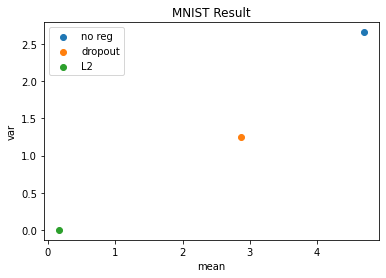

In [42]:
# acc
mnist_no_reg_loss_list = [4.0018770833333335,
 5.346458854166666,
 5.57190625,
 6.485136458333334,
 3.566426041666667,
 6.8346869791666665,
 2.1447100260416665,
 6.659199479166666,
 3.800053645833333,
 2.52507421875]

# acc 0.93
mnist_dropout_loss_list = [1.696,
 3.205,
 2.852,
 4.267,
 3.033,
 1.653,
 1.595,
 4.372,
 4.339,
 1.625]


# acc 0.97
mnist_l2_loss_list = [0.170168701171875,
 0.16914002278645834,
 0.16899208984375,
 0.16804591471354166,
 0.171884619140625,
 0.17705511067708332,
 0.17015485026041666,
 0.17682584635416668,
 0.16708610026041668,
 0.16823606770833333]


plt.scatter(y=[np.var(mnist_no_reg_loss_list)], x=[np.mean(mnist_no_reg_loss_list)], label = "no reg")
plt.scatter(y=[np.var(mnist_dropout_loss_list)], x=[np.mean(mnist_dropout_loss_list)], label = "dropout")
plt.scatter(y=[np.var(mnist_l2_loss_list)], x=[np.mean(mnist_l2_loss_list)], label = "L2")
plt.ylabel('var')
plt.xlabel('mean')
plt.title('MNIST Result')
plt.legend()
plt.show()

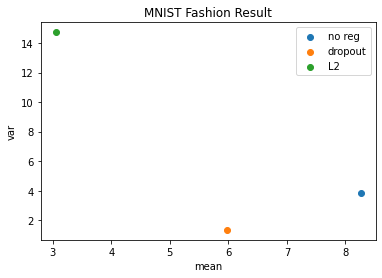

In [43]:
# acc 0.55
mnist_fashion_no_reg_loss_list = [8.284896354166667,
 9.348185416666666,
 7.466494791666666,
 5.440867708333333,
 6.876169791666666,
 7.5873390625,
 7.510666666666666,
 12.9189375,
 10.029638541666667,
 7.114257291666667]


# acc 0.75
mnist_fashion_dropout_loss_list = [5.141,
 6.04,
 8.267,
 6.292,
 4.7,
 6.607,
 7.341,
 4.264,
 5.92,
 5.155]


# acc 0.84
mnist_fashion_l2_loss_list = [0.7660436848958333,
 0.626580859375,
 0.5297130859375,
 9.730785416666667,
 9.997573958333334,
 6.594867708333333,
 0.5322341796875,
 0.6875259114583333,
 0.5513381510416666,
 0.5688837239583333]


plt.scatter(y=[np.var(mnist_fashion_no_reg_loss_list)], x=[np.mean(mnist_fashion_no_reg_loss_list)], label = "no reg")
plt.scatter(y=[np.var(mnist_fashion_dropout_loss_list)], x=[np.mean(mnist_fashion_dropout_loss_list)], label = "dropout")
plt.scatter(y=[np.var(mnist_fashion_l2_loss_list)], x=[np.mean(mnist_fashion_l2_loss_list)], label = "L2")
plt.ylabel('var')
plt.xlabel('mean')
plt.title('MNIST Fashion Result')
plt.legend()
plt.show()